# Машинное обучение, ВМК МГУ

## Практическое задание 4

### Общая информация
Дата выдачи: 10.03.2018

Мягкий дедлайн: 25.03.2018 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01.04.2018

ФИО: Лютов Владимир Сергеевич

### О задании

__Первая часть__ задания посвящена реализации различных слоёв нейронной сети.

__Вторая часть__ задания посвящена реализации алгоритма обратного распространения ошибки и обучение нейросети на задаче распознавания рукописных цифр MNIST.

__Бонусная часть__ задания посвящена реализации сверточного слоя и пулинга для улучшения решения задачи классификации из предыдущего пункта.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за основную часть работы — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-Username.ipynb, где Username — Ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-IvanovIvan.ipynb). Модуль с кодом layers.py нужно отправить в Яндекс.Контест, а также ноутбук и layers.py в anytask.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Ссылка на яндекс.контест:

1. МГУ: https://contest.yandex.ru/contest/7700/problems/
2. ВШЭ: https://official.contest.yandex.ru/contest/7700/problems/

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

**Оценка:** 10

**Номер посылки в контесте:** 11433326

## Часть 1. Реализация слоёв графа вычислений

В этом задании мы реализуем граф вычислений для задачи распознавания изображений рукописных цифр на примере датасета [MNIST](http://yann.lecun.com/exdb/mnist/) — в частности, эта часть посвящена реализации всех требующихся для построения графа слоёв.

Указанная задача является задачей классификации на $K = 10$ классов, поэтому будем строить граф вычислений, выходной слой которого будет содержать 10 нейронов, $k$-ый из которых вычисляет оценку принадлежности объекта $k$-ому классу. В качестве функционала качества в данной задаче будем использовать **кросс-энтропию**:

$$Q(a, X) = \frac{1}{l}\sum_{i=1}^l \sum_{k=1}^K [y_i = k] \log a_k(x_i),$$
где

$X = \{ (x_i, y_i)\}_{i=1}^l, \, y_i \in \{1, \dots, K\},$ — обучающая выборка,

$a(x) = (a_k(x))_{k=1}^K \in \mathbb{R}^K$ — прогноз графа вычислений для объекта $x$, состоящий из выходов $K$ нейронов выходного слоя (т.е. $a_k(x)$ — оценка принадлежности объекта $x$ классу $k$, построенная при помощи заданного графа вычислений).

Нейрнонные сети обучаются с использованием стохастических методов оптимизации, однако для ускорения обучения и большей стабильности за один проход параметры оптимизируются по батчу — набору из нескольких тренировочных примеров, так же batch_size является дополнительной размерностью для входящих в слой тензоров.

Для начала определим класс Layer, реализующий тождественный слой, который будет являться базовым классом для всех последующих.

**Задание 1 (1 балл).**

Используя приведенные прототипы, реализуйте слой, применяющий функцию активации ReLU (Rectified Linear Unit) поэлементно к каждому из входов слоя:
$$\text{ReLU}(z) = \max (0, z)$$

**Задание 2 (1 балл).**

Используя указанные прототипы, реализуйте полносвязный слой, выход которого вычисляется следующим образом (подробнее в соответствующей [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/lecture-notes/lecture11-dl.pdf)):

$$f(v; W, b)= Wv + b, $$

где
* v — выход предыдущего слоя (вектор размера num_inputs);
* W — матрица весов [num_inputs, num_outputs];
* b — столбец свободных членов (вектор размера num_outputs).

При создании полносвязного слоя веса $W, \; b$ необходимо проинициализировать веса с помощью GLOROT (какой именно вариант неважно). Про GLOROT можно прочитать здесь:
1. Простой пост: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
2. Статья с математикой: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

При каждом вызове backward() необходимо расчитать градиенты по выходу, используя chain-rule, и сделать один шаг градиентного спуска.

**Задание 3 (1 балл).**

Как было сказано ранее, в качестве функционала качества в данной задаче мы будем использовать кросс-энтропию. Используя прототипы ниже, реализуйте вычисление данного функционала и его градиента по выходам графа вычислений.

Кросс-энтропия предполагает, что модель для каждого объекта выдает вероятности принадлежности к каждому из $K$ классов, т.е. что для одного объекта все $K$ вероятностей неотрицательны и суммируются в 1. В нашем же случае в построении графа участвуют только полносвязный и ReLU слои, а потому выходы графа не являются вероятностями — как правило, в этом случае прогноз $a(x)$ модели нормируется при помощи функции softmax следующим образом:

$$\text{softmax}(a_k(x)) = \frac{\exp(a_k(x))}{\sum_{k=1}^K \exp(a_k(x))}.$$

При реализации указанных функций предполагается, что переданные в качестве параметров оценки принадлежности объектов классам не являются нормированными (их еще называют логитами), но при вычислении указанных величин используйте указанное выше преобразование для приведения этих оценок к корректному виду.

## Часть 2. Реализация и применение графа вычислений

В этой части мы научимся объединять слои в единый граф вычислений, а также использовать его для прямого прохода (вычисления прогнозов на объектах) и обратного прохода (обновление обучаемых параметров графа), после чего у нас появится возможность обучить граф. Для простоты реализации будем считать, что в нашем случае граф вычислений задается как список (python list) слоёв из числа реализованных ранее.

Ниже приведен код для скачивания датасета MNIST с официального сайта. Датасет делится на тренировочную и тестовую части. Тренировочная дополнительно разбивается на тренировочную и валидационную.

In [2]:
import sys
import os
import time
import gzip
from urllib.request import urlretrieve

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape((-1, 1, 28, 28))
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

Посмотрим на несколько объектов из этого датасета.

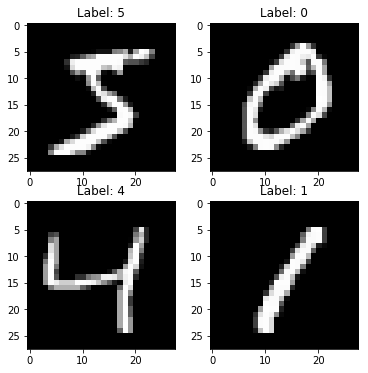

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]),cmap='gray');

In [4]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_std[X_std <= 1e-3] = 1
X_train = (X_train - X_mean) / X_std[np.newaxis, :]
X_val = (X_val - X_mean) / X_std[np.newaxis, :]

**Задание 4 (2 балла).**

Используя прототип ниже, реализуйте прямой и обратный проход по графу вычислений и функцию для получения предсказаний метки класса.

In [5]:
class NeuralNetwork:
    def __init__(self, layers):
        """
        layers — list of Layer objects
        """
        
        self.layers = layers
        self.inputs = []
        
    def forward(self, X):
        """
        Compute activations of all network layers by applying them sequentially.
        Return a list of activations for each layer. 
        Make sure last activation corresponds to network logits.
        """
        
        activations = []
        self.inputs = [X]

        for l in self.layers:
            self.inputs.append(l.forward(self.inputs[-1]))
        
        activations = self.inputs[1:]
        self.inputs = self.inputs[:-1]

        assert len(activations) == len(self.layers)
        return activations

    def predict(self, X):
        """
        Use network to predict the most likely class for each sample.
        """
        
        return self.forward(X)[-1].argmax(axis=1)
        
    def backward(self, X, y):
        """
        Train your network on a given batch of X and y.
        You first need to run forward to get all layer activations.
        Then you can run layer.backward going from last to first layer.

        After you called backward for all layers, all Dense layers have already made one gradient step.
        """

        # Get the layer activations
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
        logits = layer_activations[-1]

        # Compute the loss and the initial gradient
        loss = softmax_crossentropy_with_logits(logits, y)
        grad_output = grad_softmax_crossentropy_with_logits(logits, y)

        # propagate gradients through network layers using .backward
        # hint: start from last layer and move to earlier layers
        assert len(self.layers) == len(self.inputs)
        
        for l, i in reversed(list(zip(self.layers, self.inputs))):
            grad_output = l.backward(i, grad_output)
        

        return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%. 

Ниже определена функции для итерации по батчам, принимающая на вход картинки, матки классов, а также размер батча и флаг отвечающий за перемешивание примеров.

In [6]:
from tqdm import tnrange

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, seed=1234):
    assert len(inputs) == len(targets)
    
    indices = np.arange(len(inputs)).astype(np.int32)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    for start_idx in tnrange(0, len(inputs), batchsize):
        batch = indices[start_idx:start_idx + batchsize]
        
        yield inputs[batch], targets[batch]

Ниже приведены функции для обучения модели и отслеживания значения loss на тренироворочной части и на валидации.

Epoch 14
Train accuracy: 0.98674
Val accuracy: 0.9613


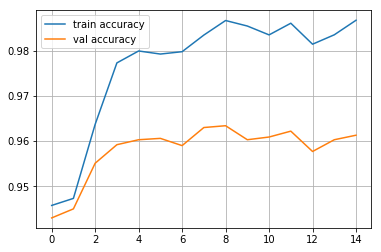

In [7]:
from layers import Dense, ReLU, softmax_crossentropy_with_logits, grad_softmax_crossentropy_with_logits

layers = []
hidden_layers_size = 40
layers.append(Dense(X_train.shape[1], hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, hidden_layers_size))
layers.append(ReLU())
layers.append(Dense(hidden_layers_size, 10))

model = NeuralNetwork(layers)

from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(15):
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        model.backward(x_batch, y_batch)
    
    train_log.append(np.mean(model.predict(X_train) == y_train))
    val_log.append(np.mean(model.predict(X_val) == y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Часть 3. Дополнительные слои

В этой части предлагается реализовать сверточный слой и слой maxpooling, а также разработать свою архитектуру графа вычислений с их использованием для повышения качества на валидационной выборке.

**Задание 6 (2 балла).** Реализуйте сверточный слой.

Рассмотрим один сверточный слой. Пусть на вход поступает изображение $X^l$ с $channels$ каналами, а сверточный слой $W$ имеет размер $k_1 \times k_2 \times channels$. Тогда применение слоя можно выразить следующим образом:

$$x_{ij}^{l} = \sum_{m=0}^{k_1 - 1} \sum_{n=0}^{k_2 - 1} \sum_{c=0}^{channels} w_{m, n, c}^{l} x_{i+m, j+n, c}^{l-1}$$

**Задание 7 (1 балл).** Реализуйте слой макспулинга.

Ниже, на картинке, можно увидеть пример применения операции макспулинга с ядром размера 2x2 (слой применяется раздельно для каждого канала изображения).

<img src="https://cambridgespark.com/content/tutorials/convolutional-neural-networks-with-keras/figures/pool.png">

**Задание 8 (1 балл).** Реализуйте слой для перевода n-мерного тензора в матрицу. Данный слой понадобится вам после использования сверточных слоев для перевода четырехмерного тензора в матрицу и дальнейшего использования результата в полносвязном слое для предсказания ненормированных вероятностей классов.

**Задание 9 (1 балл).** Подберите архитектуру сети, используя сверточные слои и слои макспулинга и превзойдите качество полносвязной сети.

In [8]:
from layers import Conv2d, Maxpool2d, Flatten
layers = [
    Conv2d(1, 6, (5, 5)),
    ReLU(),
    Maxpool2d(2),
    Conv2d(6, 16, (5, 5)),
    ReLU(),
    Maxpool2d(2),
    Flatten(),
    Dense(256, 64),
    Dense(64, 10)
]
model = NeuralNetwork(layers)

In [9]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.98176
Val accuracy: 0.9764


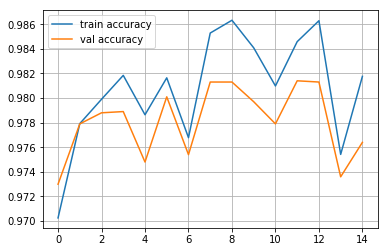

In [10]:
def predict(model, X, batchsize=32):
    result = []
    for x_batch, _ in iterate_minibatches(X, X, batchsize=batchsize, shuffle=False):
        result.extend(model.predict(x_batch.reshape((-1, 1, 28, 28))).tolist())
    return np.array(result)

for epoch in range(15):
    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        model.backward(x_batch.reshape((-1, 1, 28, 28)), y_batch)
    
    train_log.append(np.mean(predict(model, X_train) == y_train))
    val_log.append(np.mean(predict(model, X_val) == y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

## Часть 4. Мемы

**Задание 10 (0.2 балла).** Какой мем из уже прошедшего 2k17 года вам запомнился больше всего? 

**Задание 11 (0.2 балла).** А какой из появившихся в 2k!8 вам понравился больше всего?

**Задание 12 (0.2 балла).** А здесь напишите фидбек по заданию :)